This is a vanilla run of LDA on some Application Logging XML to visualize what kind of topic distributions might be found. Semi-structured data contains more consistent "noise" than purely unstructured, due to the continued presence of tags in every line. This makes it initially less suitable for directly running LDA on without defining filters for the tags. Anyways, let's see what LDA with some noise reduction included looks like below and see how it affects topic coherence.

In [ ]:
!pip install gensim
!pip install pyLDAvis
import pyLDAvis
import pandas as pd
import numpy as np
import gensim
from gensim.utils import smart_open, simple_preprocess
from gensim.corpora.wikicorpus import _extract_pages, filter_wiki
from gensim.parsing.preprocessing import STOPWORDS


In [241]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

# read data into an array
lines = []
tokenz = []
with open('data.xes') as infile:
    for line in infile:
        lines += [line]
        tokenz += [tokenize(line)]

In [242]:
dictionary = gensim.corpora.Dictionary(tokenz)

In [243]:
print(dictionary)

Dictionary(273 unique tokens: ['encoding', 'utf', 'version', 'xml', 'conforms']...)


In [244]:
# Keep tokens that occur more than 5 times and each are less than 10% of the corpus
dictionary.filter_extremes(no_below=5, no_above=0.1)
print(dictionary)

Dictionary(165 unique tokens: ['log', 'standard', 'xes', 'http', 'www']...)


In [245]:
corpus = [dictionary.doc2bow(text) for text in tokenz]

In [85]:
# Coherence models are used to determine roughly how many topics we expect are present in the dataset
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus,texts, limit, start, step, ctype):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,num_topics=num_topics)                
        model_list.append(model)
        cm = CoherenceModel(model=model, dictionary=dictionary, corpus=corpus, texts=texts, coherence=ctype)
        coherence_values.append(cm.get_coherence())
            
    return model_list, coherence_values

# Used for u_mass coherence model insight
def get_gradient_values(coherence_values):
    gradient_values = [0]
    gradient_values += [(y1 - y0)/step for y0,y1 in zip(coherence_values[:-1],coherence_values[1:])]
    return gradient_values

In [86]:
# Compute u_mass and c_v coherence scores to compare results

model_list1, coherence_values1 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=None, start=2, limit=40, step=1, ctype='u_mass')
# Get the gradient values (i.e. rate of change) for u_mass coherence values as well
gradient_values1 = get_gradient_values(coherence_values1)

model_list2, coherence_values2 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenz, start=2, limit=40, step=1, ctype='c_v')
gradient_values2 = get_gradient_values(coherence_values2)

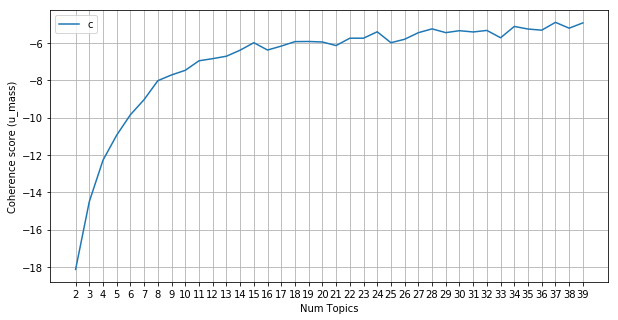

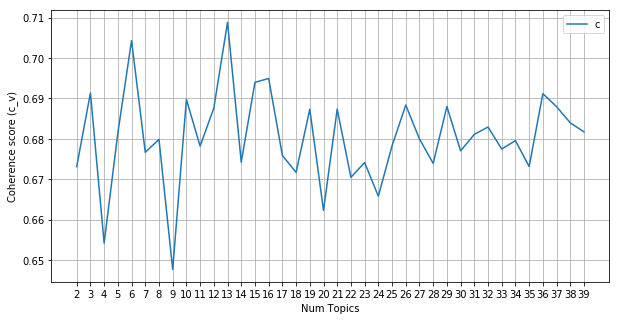

In [69]:
%matplotlib inline
# Plot coherence scores
import numpy as np
import matplotlib.pyplot as plt
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(x, coherence_values1)
plt.xticks(np.arange(start, limit, step=step))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (u_mass)")
plt.legend(("coherence_values"), loc='best')
plt.show()

plt.figure(figsize=(10,5))
plt.grid()
plt.plot(x, coherence_values2)
plt.xticks(np.arange(start, limit, step=step))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score (c_v)")
plt.legend(("coherence_values"), loc='best')
plt.show()

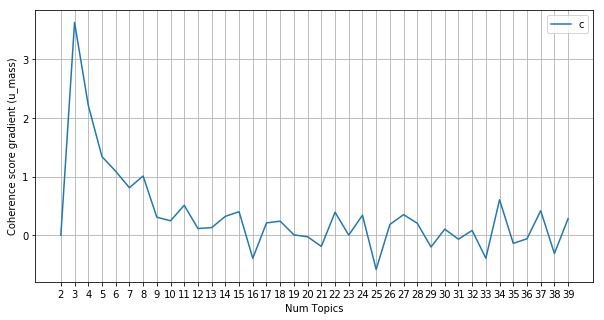

In [70]:
# Plot the gradients

plt.figure(figsize=(10,5))
plt.grid()
plt.plot(x, gradient_values1)
plt.xticks(np.arange(start, limit, step=step))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score gradient (u_mass)")
plt.legend(("coherence_values"), loc='best')
plt.show()

#plt.figure(figsize=(10,5))
#plt.grid()
#plt.plot(x, gradient_values2)
#plt.xticks(np.arange(start, limit, step=step))
#plt.xlabel("Num Topics")
#plt.ylabel("Coherence score gradient (c_v)")
#plt.legend(("coherence_values"), loc='best')
#plt.show()

The two coherence scores give close estimates to the number of topics as being 6 or 13:
- for C_V these are literal peaks and easy visualized by the coherence score peaking at either 6 or 13 topics
- for U_Mass the coherence score continually gains so looking at the gradient of change in the coherence value is more useful. We can see the gradient's curve looks roughly like an exponential decay curve with a half-life around 6 topics and generally level around 13 topics.

Both of these options are useful, with 6 topics hopefully being more generally interpretable and 13 topics being granular enough to capture all relevant topics.

In [74]:
import pyLDAvis.gensim
# 6 topic LDA model
pyLDAvis.display(pyLDAvis.gensim.prepare(model_list1[4],corpus,dictionary))

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Interpretation of topics:
<br />1 - A detailed timestamp for an application (hamcrest?)
<br />2 - An app was run using a file, which completed (unclear if app used filename as input or the app's host process is the filename)
<br />3 - A thread running a process completed its job
<br />4 - Something was started (likely an event corresponding to an app, based on other topics)
<br />5 - A status message about an app/process that is currently running
<br />6 - A test operating on a node

<br />Further insights on topic relations:
<br /> - Notice that groups 1 and 5 clustered together, their general category is indeed centered around status/information updates.
<br />
<br /> - Also notice that groups 2,3,4 are also nearly clustered and all have to do with an app or thread starting and stopping.
<br />
<br /> - Given the positioning of the topics we can also generally interpret the axes:
<br /> -- X-axis as defining whether a topic is more related to applications that are running (left side) or more related to diagonostics (right side). 
<br /> -- Y-axis we define whether a topic is more of an information update (downwards) or more of an indication of an event having occurred (upwards).

In [76]:
# 13 topic LDA Model
pyLDAvis.display(pyLDAvis.gensim.prepare(model_list1[11],corpus,dictionary))

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Interpretation of Topics
<br /> 1 - Node info message
<br /> 2 - A general notification with a description of what happened
<br /> 3 - An application was started
<br /> 4 - A specific process returned (not clear what linenr, joinpoint, eunit are)
<br /> 5 - A statement about a "junitblock" object
<br /> 6 - An event relating to a file changed or the event changed (unclear which)
<br /> 7 - A list of utilities related to a "junitblock" object
<br /> 8 - A timestamp relating to a test
<br /> 9 - The time it took to run an application
<br /> 10 - 'junitcore' finished running
<br /> 11 - The 'hamcrest' event was successful (not sure what this is)
<br /> 12 - Information about an event ending relating to resources
<br /> 13 - Thread that is running the application


<br />Further insights on topic relations:
<br /> - When we jumped from 6 topics to 13 topics, the groupings got more specific which meant that I needed more domain knowledge to properly understand what each group represents. Thus, I had to use a little guesswork since I am unfamiliar with the applications and processes that are mentioned in this text data. I refine my understanding by looking at clear aggregates as well as defining the Axes.
<br /> - Since we have more groups, this also means that the axes have more meaning and can help with understanding the specific topics and their relations to each other:
<br /> 
<br /> - Groups 9 and 13 are near each other and are clearly related, together they define which thread is running an app and how much time has elapsed.
<br /> - Groups 5 and 7 both deal with some 'junitblock' which I am unfamiliar with.
<br /> - Groups 4 and 6 both indicate some kind of action was taken (4 = action complete, 6 = transition of some kind), Group 11 also implies that the 'hamcrest' event (whatever that is) successfully ran.
<br /> - Using these larger groupings, we can define the axes:
<br /> -- Along the X-axes we have "framework methods info" (left) and "app information" (right)
<br /> -- Along the Y-axes we have "state change information" (downward) and "running information" (upward)

<br /> - As a sanity check, Topic 1 sits pretty near to the center of the topic plot. Conceptually, topic 1 is grouping messages about a node- which can be thought of as being between something running and something changing state since it must be in an available state to begin hosting an application, is live when running an app, but apparently has no runtime associated (there appears to be no uptime message in this dataset directly associated with the node). Also, presumably the node would host both frameworks to run things as well as running application itself and understandably is going to be found more commonly associated with a consistent architecture rather than variuos individual applications.

<br /> - Finally, let's put the proof to this sanity check and open up some of the points from inside Group 1 to verify these claims and understand once and for all what messages these are.


In [164]:
# Note: the topic numbers in gensims are not 1:1 with pyLDAvis ... a long-standing irk in the NLP world.
# Looks like gensim thinks of this as topic 3.
model_list1[11].show_topic(3)

[('regionstr', 0.28045166),
 ('node', 0.28045166),
 ('internal', 0.045230389),
 ('parentrunner', 0.042372033),
 ('methodsorter', 0.040202025),
 ('gettestclass', 0.034703296),
 ('object', 0.032449074),
 ('reflect', 0.031064104),
 ('compare', 0.030883582),
 ('method', 0.030661596)]

In [239]:
# AFAIK, you can't get easily pick up the values that fit a group defined by LDA. You have to re-solve your initial data to extract those labels:

# Method 1 is to use a threshold to tag any entry with any topic clearing a base probability value. This allows multiple topic groups per entry in theory:

topics_m1 = {}
topic_entries_m1 = {}
for n0 in range(0,13,1):
    topics_m1[n0] = []
    topic_entries_m1[n0] = []
    
# Get the indices lists for each topic, by topic
n = 0
for entry in corpus:
    for n1 in range(0,13,1):
        try:
            if dict(model_list1[11][entry])[n1] > 0.6:
                topics_m1[n1] += [(n,entry)]
        except KeyError:
            pass
    
    n += 1
    
# Pull out the actual words from the corpus!
for n2 in range(0,13,1):
    index_values = list(dict(topics_m1[n2]).keys())
    topic_entries_m1[n2] = list( tokenz[i] for i in index_values )

In [207]:
# Method 2 uses a max topic selection to guarantee exactly 1 topic per entry (note that it can fail if 2 topics have the exact same
# probability due to being forced to pick one of the two. don't blame me.):

topics_m2 = {}
topic_entries_m2 = {}
for n0 in range(0,13,1):
    topics_m2[n0] = []
    topic_entries_m2[n0] = []
    
# Get the indices lists for each topic, by topic
n = 0
for entry in corpus:
    try:
        topic_dist_values = dict(model_list1[11][entry])
        max_topic = max(topic_dist_values, key=topic_dist_values.get)
        topics_m2[max_topic] += [(n,entry)]
    except KeyError:
        pass
    
    n += 1
    
# Pull out the actual words from the corpus!
for n2 in range(0,13,1):
    index_values = list(dict(topics_m2[n2]).keys())
    topic_entries_m2[n2] = list( tokenz[i] for i in index_values )    

In [262]:
# Check if the word node is in any of these entries ... using Method 1
for n3 in range(1,13,1):
    for entry in topic_entries_m1[n3]:
        if 'node' in entry:
            print('yes')
            print(n3)
            break
        else:
            pass

In [286]:
# Check if the word node is in any of these entries ... using Method 2
for n3 in range(1,13,1):
    for entry in topic_entries_m2[n3]:
        if 'node' in entry:
            print('Topic containing "node" is:',n3)
            break
        else:
            pass

Topic containing "node" is: 3


Method 2 confirmed that the topic group was 3 and we found the keyword 'node' so I'll use the values it picked up to investigate.

In [316]:
# Pick out a few indices that contain 'node' or 'regionstr' the two most characteristic terms of this group.
strong_ix = []
double_ix = []
for index in list(dict(topics_m2[3]).keys()):
    if 'node' in lines[index] or 'regionstr' in lines[index]:
        strong_ix += [index]     

In [320]:
# Check values of an entry
i = strong_ix[233]
model_list1[11][corpus[i]], tokenz[i], lines[i]
for item in lines[i-14:i+2]:
    print(item)

		<event>

			<string key="apploc:filename" value="MethodSorter.java"/>

			<string key="org:resource" value="1"/>

			<string key="apploc:node" value="CalculatorTest"/>

			<string key="apploc:linenr" value="14"/>

			<string key="concept:name" value="org.junit.internal.MethodSorter$1.compare(java.lang.Object,java.lang.Object)"/>

			<string key="apploc:tier" value="hamcrest-core-1.3"/>

			<string key="apprun:threadid" value="1"/>

			<string key="apploc:app" value="junit-4.12"/>

			<string key="apploc:joinpoint" value="org.junit.internal.MethodSorter$1.compare(java.lang.Object,java.lang.Object)"/>

			<date key="time:timestamp" value="2016-08-15T10:53:29.514+02:00"/>

			<string key="lifecycle:transition" value="start"/>

			<string key="apploc:etype" value="call"/>

			<string key="apprun:nanotime" value="4842804014210"/>

			<string key="apploc:regionstr" value=""/>

		</event>



In [302]:
# Check values of an entry 2
i = strong_ix[100]
#model_list1[11][corpus[i]], tokenz[i]
for item in lines[i-3:i+13]:
    print(item)

		<event>

			<string key="apploc:filename" value="RunnerBuilder.java"/>

			<string key="org:resource" value="1"/>

			<string key="apploc:node" value="CalculatorTest"/>

			<string key="apploc:linenr" value="59"/>

			<string key="concept:name" value="org.junit.runners.model.RunnerBuilder.safeRunnerForClass(java.lang.Class)"/>

			<string key="apploc:tier" value="hamcrest-core-1.3"/>

			<string key="apprun:threadid" value="1"/>

			<string key="apploc:app" value="junit-4.12"/>

			<string key="apploc:joinpoint" value="org.junit.runners.model.RunnerBuilder.safeRunnerForClass(java.lang.Class)"/>

			<date key="time:timestamp" value="2016-08-15T10:53:29.401+02:00"/>

			<string key="lifecycle:transition" value="complete"/>

			<string key="apploc:etype" value="return"/>

			<string key="apprun:nanotime" value="4842690250745"/>

			<string key="apploc:regionstr" value=""/>

		</event>



In [327]:
# Check values of an entry 2
i = strong_ix[-1]
#model_list1[11][corpus[i]], tokenz[i]
for item in lines[i-14:i+2]:
    print(item)

		<event>

			<string key="apploc:filename" value="JUnitCore.java"/>

			<string key="org:resource" value="1"/>

			<string key="apploc:node" value="CalculatorTest"/>

			<string key="apploc:linenr" value="36"/>

			<string key="concept:name" value="org.junit.runner.JUnitCore.main(java.lang.String[])"/>

			<string key="apploc:tier" value="hamcrest-core-1.3"/>

			<string key="apprun:threadid" value="1"/>

			<string key="apploc:app" value="junit-4.12"/>

			<string key="apploc:joinpoint" value="org.junit.runner.JUnitCore.main(java.lang.String[])"/>

			<date key="time:timestamp" value="2016-08-15T10:53:29.807+02:00"/>

			<string key="lifecycle:transition" value="complete"/>

			<string key="apploc:etype" value="return"/>

			<string key="apprun:nanotime" value="4843095538592"/>

			<string key="apploc:regionstr" value=""/>

		</event>



Amazing! It seems pretty obvious now that both "node" and "regionstr" are details about an application that's being run. They're both string keys tagged with the "apploc" tag and appear to always be present together. This is the lowest level interpretation of the relationship of these two key words based on these few data points we've manually observed. This confirms our grand theoretical investigation above which was based on trends across the entire dataset.

<br /> The applied takeaway from this investigation is actually much simpler than the inference done above, though that is insightful in understanding a problem space as well as the robustness/correctness of your LDA model's classification ability. The most basic thing we needed to prove was that each group implied a distinctly different topic. As long as there is no major overlap between topic groups, we can use these labels to enrich future datasets (as well as the training set) with topic tags for any further ML projects.

... Optional Trivia below:

In [ ]:
# Optional: see what gensim thinks the most understandable topics are
#model_list1[11].top_topics(dictionary=dictionary, corpus=corpus)

In [78]:
# This is what noise looks like, this is an old plot that I kept around from before I applied the frequency filter.
# notice how none of the topics have any strong members and are hard to interpret.
# 6 topic LDA with noise still present (I skipped frequency filtering, but still removed stopwords and did tokenization)
pyLDAvis.display(pyLDAvis.gensim.prepare(model_list2[4],corpus,dictionary))

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
